In [1]:
import shutup
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tsgcn.simulation import MsprimeSimulation, run_sims
from tsgcn.util import get_idle_gpu
from tsgcn.data import TreeSequenceData, TreeSequencesDataset, windowed_div_from_ts, compute_ys
from tsgcn.model import BiGCNModel, BiGCNEncoder

import tskit

shutup.please()

/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is depr

In [2]:
# this device variable will get used later during training
device = torch.device(f"cuda:{get_idle_gpu()}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [3]:
## CONSTANTS
seed = 11379
num_reps = 1_000
sp_name = "HomSap"
chrom = None
length = 1_000_000
model_name ="OutOfAfrica_3G09"
sample_size=10
num_windows = 100
model_num_windows = 20
HomSap_chr13_OOA = MsprimeSimulation(seed, num_reps, sp_name, model_name, "data/raw/", chrom, length, sample_size, n_workers=512)
model_breaks = np.linspace(0, HomSap_chr13_OOA.contig.length, model_num_windows+1)
out_breaks = np.linspace(0, HomSap_chr13_OOA.contig.length, num_windows+1)

In [4]:
run_sims(HomSap_chr13_OOA)

In [5]:
# Just exploring the output of convert_tseq
from tsgcn.util import convert_tseq
ts=tskit.load(HomSap_chr13_OOA.ts_paths[0])
eix, ei, nf, sq = convert_tseq(ts)
a=TreeSequenceData(edge_index=eix, edge_interval=ei, x = nf, sequence_length=sq)

In [6]:
# Importing our dataset
dataset = TreeSequencesDataset("data/", HomSap_chr13_OOA.sims_path,seeds=HomSap_chr13_OOA.seed_array, y_name="windowed-diversity")

In [7]:
compute_ys(dataset, windowed_div_from_ts, "windowed-diversity", num_windows=num_windows, n_workers=256)

In [8]:
def node_num_child(ts):
    stats = np.zeros((ts.num_nodes, ), dtype=np.float32)
    for tree in ts.trees():
        for u in tree.nodes():
            stats[u] += tree.num_children(u)
    return torch.FloatTensor(stats)

In [9]:
dataset.len()

1000

In [10]:
dataset[0]

TreeSequenceData(x=[1419, 1], edge_index=[2, 7494], edge_interval=[2, 7494], sequence_length=1000000.0, y=[100])

In [11]:
test = BiGCNEncoder(model_breaks, device, dataset[0].num_features, dataset[0].num_features)

In [12]:
test(dataset[0])

tensor([[ 1.0153],
        [ 0.5123],
        [ 0.7349],
        ...,
        [-1.5877],
        [-1.9313],
        [-2.1125]], grad_fn=<AddmmBackward0>)

In [13]:
from torch.utils.data import random_split

torch.manual_seed(123)
train_set, valid_set, test_set = random_split(dataset,[70*dataset.len()//100, 15*dataset.len()//100, 15*dataset.len()//100])

trainloader = DataLoader(train_set, batch_size=1, shuffle=True)
validloader = DataLoader(valid_set, batch_size=1, shuffle=True)
testloader = DataLoader(test_set, batch_size=1, shuffle=True)

In [14]:
def get_y(batch):
    #return batch.x[:,0].unsqueeze(1)
    return batch.y.unsqueeze(1)

In [15]:
torch.manual_seed(1793335)
model = BiGCNModel(device, num_encoder_in_features=dataset.num_features, num_encoder_out_features=2,
                    breaks=out_breaks, pooling="windowed_sum", out_breaks=out_breaks)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=2e-4)
num_epochs=60
criterion = torch.nn.MSELoss()
last_test_loss = 0

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    num_batches = 0
    for batch in trainloader:
        num_batches+=1
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        #print(output.shape, batch.x[:,0].unsqueeze(1).shape)
        loss = criterion(output,get_y(batch))
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    
    train_avg_loss = epoch_loss / num_batches
    val_loss = 0
    model.eval()
    num_batches = 0
    for batch in validloader:
        num_batches+=1
        batch.to(device)
        output = model(batch)
        loss = criterion(output,get_y(batch))
        val_loss += loss.item()
    val_avg_loss = val_loss/num_batches
    last_test_loss = train_avg_loss
    print(f"Epochs: {epoch} | epoch avg. loss: {train_avg_loss:.8f} | validation avg. loss: {val_avg_loss:.8f}")
    if abs(train_avg_loss-last_test_loss) < 1e-3: 
        print("early stopping")
        break

Epochs: 0 | epoch avg. loss: 1241.29596850 | validation avg. loss: 281.29187703
Epochs: 1 | epoch avg. loss: 153.26687114 | validation avg. loss: 40.19534017
Epochs: 2 | epoch avg. loss: 53.48861851 | validation avg. loss: 6.81604572
Epochs: 3 | epoch avg. loss: 29.02268457 | validation avg. loss: 12.25025060
Epochs: 4 | epoch avg. loss: 16.76356234 | validation avg. loss: 21.22174839
Epochs: 5 | epoch avg. loss: 9.70674255 | validation avg. loss: 27.67315196
Epochs: 6 | epoch avg. loss: 5.67416061 | validation avg. loss: 24.29974139
Epochs: 7 | epoch avg. loss: 3.18036984 | validation avg. loss: 14.79213428
Epochs: 8 | epoch avg. loss: 1.56990131 | validation avg. loss: 7.03296845
Epochs: 9 | epoch avg. loss: 0.64680307 | validation avg. loss: 2.34084695
Epochs: 10 | epoch avg. loss: 0.22735589 | validation avg. loss: 0.61575762
Epochs: 11 | epoch avg. loss: 0.09939922 | validation avg. loss: 0.19389054
Epochs: 12 | epoch avg. loss: 0.07638138 | validation avg. loss: 0.11263502
Epochs

In [17]:
model.eval()
predictions = []
real = []

for batch in testloader:
    
    output = model(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(get_y(batch).detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

In [18]:
torch.save(model.encoder.state_dict(), "trained_encoder.pt")

In [19]:
model.encoder

BiGCNEncoder(
  (lin1): Linear(in_features=1, out_features=2, bias=True)
  (conv): GCNConv(2, 2)
  (conv_f): GCNConv(2, 2)
  (conv_b): GCNConv(2, 2)
  (batch_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_f): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_b): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=6, out_features=2, bias=True)
)

In [20]:
predictions.shape

(15000, 1)

In [21]:
real.shape

(15000, 1)

In [22]:
batch = next(iter(testloader))

In [23]:
batch.to(device)
output = model(batch)
criterion(output, get_y(batch))

tensor(0.0949, device='cuda:1', grad_fn=<MseLossBackward0>)

Visualizing `Predicted~Observed` diversity within a single tree sequence

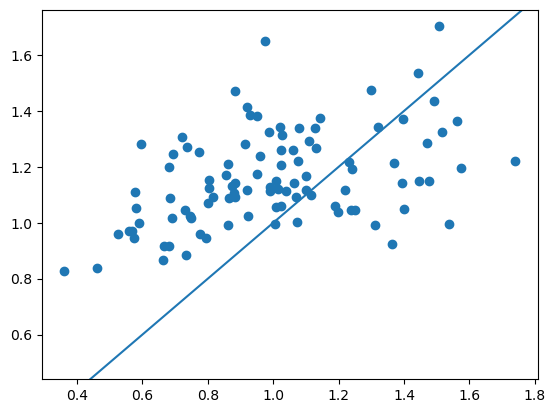

In [24]:
plt.scatter(get_y(batch).detach().cpu().numpy(), output.detach().cpu().numpy())
plt.axline((0.5,0.5), slope=1)

Now across all windows and tree sequences

In [25]:
import scipy.stats

In [26]:
# calculate r^2 of real and predictions
scipy.stats.pearsonr(real.flatten(), predictions.flatten())[0]**2

0.24580362408272113

Text(0.5, 0, 'Observed diversity')

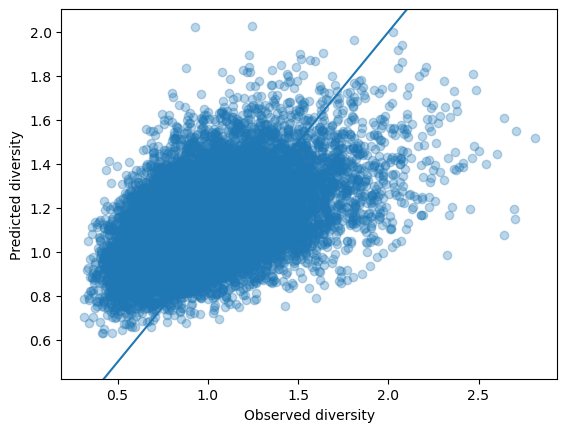

In [27]:


plt.scatter(real, predictions, alpha=0.3)
plt.axline((0.5,0.5), slope=1)

plt.ylabel('Predicted diversity')
plt.xlabel('Observed diversity')